<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Random-Walk-Prediction/blob/main/FMNP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import csv  # Import the csv module

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error,r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import linregress, ttest_1samp, norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_white
from arch import arch_model
from scipy.stats import skew, skewtest
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [45]:
import random
import os

# Set seeds for reproducibility
def set_seed(seed=1):
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Call the function to set the seed
set_seed(1)

## Raw Data

In [46]:
os.getcwd()

'd:\\RESEARCH\\Experiment'

In [ ]:
# Load the exogenous and target CSV data (make sure the CSV files are in the correct path)
df_exo = pd.read_csv('D:\\RESEARCH\\Data\\FTSE_historical_data.csv')
df_target = pd.read_csv('D:\\RESEARCH\\Data\\OIL_historical_data.csv')

In [48]:
df_exo

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-10-06 00:00:00+01:00,6527.899902,6588.299805,6527.899902,6563.700195,722223000,0.0,0.0
1,2014-10-07 00:00:00+01:00,6563.700195,6563.799805,6495.600098,6495.600098,858099000,0.0,0.0
2,2014-10-08 00:00:00+01:00,6495.600098,6502.399902,6453.799805,6482.200195,822967200,0.0,0.0
3,2014-10-09 00:00:00+01:00,6482.200195,6544.200195,6425.200195,6431.899902,864389000,0.0,0.0
4,2014-10-10 00:00:00+01:00,6431.899902,6431.899902,6328.399902,6340.000000,897708400,0.0,0.0
...,...,...,...,...,...,...,...,...
2521,2024-09-30 00:00:00+01:00,8320.799805,8324.599609,8234.000000,8237.000000,831097600,0.0,0.0
2522,2024-10-01 00:00:00+01:00,8237.000000,8291.099609,8226.200195,8276.700195,928541100,0.0,0.0
2523,2024-10-02 00:00:00+01:00,8276.700195,8322.599609,8267.599609,8290.900391,804855900,0.0,0.0
2524,2024-10-03 00:00:00+01:00,8290.900391,8332.700195,8262.000000,8282.500000,918547500,0.0,0.0


In [49]:
df_target

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-10-06 00:00:00-04:00,74.646131,75.738738,74.077067,74.782707,6058800,0.0,0.0
1,2014-10-07 00:00:00-04:00,74.494371,76.011877,74.016358,74.532310,9573500,0.0,0.0
2,2014-10-08 00:00:00-04:00,74.130177,74.759943,72.650610,74.691658,10521000,0.0,0.0
3,2014-10-09 00:00:00-04:00,74.327462,74.335051,71.853925,72.020851,14844800,0.0,0.0
4,2014-10-10 00:00:00-04:00,71.398672,72.058789,69.858404,70.617157,13965100,0.0,0.0
...,...,...,...,...,...,...,...,...
2512,2024-09-30 00:00:00-04:00,41.970001,42.470001,41.560001,41.950001,12219600,0.0,0.0
2513,2024-10-01 00:00:00-04:00,41.750000,43.590000,41.740002,43.139999,14716500,0.0,0.0
2514,2024-10-02 00:00:00-04:00,43.459999,44.180000,43.290001,43.939999,14614600,0.0,0.0
2515,2024-10-03 00:00:00-04:00,43.939999,44.939999,43.540001,44.889999,13775400,0.0,0.0


## Data preprocessing

In [50]:
# Convert 'Date' column to datetime and normalize to UTC for both datasets
df_exo['Date'] = pd.to_datetime(df_exo['Date'], utc=True)
df_target['Date'] = pd.to_datetime(df_target['Date'], utc=True)

# Remove the time part, keeping only the date
df_exo['Date'] = df_exo['Date'].dt.date
df_target['Date'] = df_target['Date'].dt.date

In [51]:
# Align exogenous and target datasets using target dates as reference, keeping all rows from target dataset
merged_df = pd.merge(df_target[['Date', 'Open', 'High', 'Low', 'Close']],
                     df_exo[['Date', 'Open']],
                     on='Date',
                     suffixes=('_target', '_exo'),
                     how='left')  # Use left join to keep all rows from the target dataset

# Fill NaN values in the exogenous data (exo columns) with the previous non-NaN values
merged_df.fillna(method='ffill', inplace=True)

C:\Users\ZHANG-PC\AppData\Local\Temp\ipykernel_17908\3394430005.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [52]:
# Corrected movement calculation: 1 if price at time t > price at t-1, else 0
merged_df['Movement_exo'] = merged_df['Open_exo'].diff().apply(lambda x: 1 if x > 0 else -1).fillna(0)
merged_df['Movement_target'] = merged_df['Close'].diff().apply(lambda x: 1 if x > 0 else -1).fillna(0)

In [53]:
# Check for missing Open prices
print("Missing exo Open prices:", merged_df['Open_exo'].isna().sum())
print("Missing target Open prices:", merged_df['Open_target'].isna().sum())

# Drop rows with missing Open prices if any exist
merged_df.dropna(subset=['Open_exo', 'Open_target'], inplace=True)

Missing exo Open prices: 0
Missing target Open prices: 0


In [54]:
merged_df['Close_T+1'] = merged_df['Close'].shift(-1)
merged_df['Open_exo_T+1'] = merged_df['Open_exo'].shift(-1)
merged_df['Movement_exo_T+1'] = merged_df['Movement_exo'].shift(-1)
merged_df['Movement_target_T+1'] = merged_df['Movement_target'].shift(-1)

In [55]:
merged_df

,Date,Open_target,High,Low,Close,Open_exo,Movement_exo,Movement_target,Close_T+1,Open_exo_T+1,Movement_exo_T+1,Movement_target_T+1
0,2014-10-06,74.646131,75.738738,74.077067,74.782707,6563.700195,-1,-1,74.532310,6495.600098,-1.0,-1.0
1,2014-10-07,74.494371,76.011877,74.016358,74.532310,6495.600098,-1,-1,74.691658,6482.200195,-1.0,1.0
2,2014-10-08,74.130177,74.759943,72.650610,74.691658,6482.200195,-1,1,72.020851,6431.899902,-1.0,-1.0
3,2014-10-09,74.327462,74.335051,71.853925,72.020851,6431.899902,-1,-1,70.617157,6431.899902,-1.0,-1.0
4,2014-10-10,71.398672,72.058789,69.858404,70.617157,6431.899902,-1,-1,68.993408,6366.200195,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-09-30,41.970001,42.470001,41.560001,41.950001,8237.000000,-1,-1,43.139999,8276.700195,1.0,1.0
2513,2024-10-01,41.750000,43.590000,41.740002,43.139999,8276.700195,1,1,43.939999,8290.900391,1.0,1.0
2514,2024-10-02,43.459999,44.180000,43.290001,43.939999,8290.900391,1,1,44.889999,8282.500000,-1.0,1.0
2515,2024-10-03,43.939999,44.939999,43.540001,44.889999,8282.500000,-1,1,45.459999,8282.500000,-1.0,1.0


In [56]:
new_df = merged_df[1:2501]

In [57]:
new_df

,Date,Open_target,High,Low,Close,Open_exo,Movement_exo,Movement_target,Close_T+1,Open_exo_T+1,Movement_exo_T+1,Movement_target_T+1
1,2014-10-07,74.494371,76.011877,74.016358,74.532310,6495.600098,-1,-1,74.691658,6482.200195,-1.0,1.0
2,2014-10-08,74.130177,74.759943,72.650610,74.691658,6482.200195,-1,1,72.020851,6431.899902,-1.0,-1.0
3,2014-10-09,74.327462,74.335051,71.853925,72.020851,6431.899902,-1,-1,70.617157,6431.899902,-1.0,-1.0
4,2014-10-10,71.398672,72.058789,69.858404,70.617157,6431.899902,-1,-1,68.993408,6366.200195,-1.0,-1.0
5,2014-10-13,70.435040,71.497295,68.849243,68.993408,6366.200195,-1,-1,67.498657,6392.700195,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2496,2024-09-06,41.200001,41.630001,40.369999,40.619999,8241.700195,-1,-1,40.410000,8270.799805,1.0,-1.0
2497,2024-09-09,40.799999,41.169998,40.349998,40.410000,8270.799805,1,-1,39.590000,8206.000000,-1.0,-1.0
2498,2024-09-10,40.480000,40.480000,39.119999,39.590000,8206.000000,-1,-1,39.570000,8193.900391,-1.0,-1.0
2499,2024-09-11,39.560001,39.770000,38.660000,39.570000,8193.900391,-1,-1,39.799999,8241.000000,1.0,1.0


Examine whether the target series is plain random walk or not

In [58]:

# Step 1: Compute the mean and standard deviation
mean = np.mean(np.array(new_df['Close'][0:2000]))
std_dev = np.std(np.array(new_df['Close'][0:2000]))

# Step 2: Standardize the series
standardized_series = (np.array(new_df['Close'][0:2000]) - mean) / std_dev
logarithmized_series = np.log(np.array(new_df['Close'][0:2000]))

In [59]:
def standardize_series(series):
    """
    Standardize a time series to have mean 0 and standard deviation 1.
    """
    mean = np.mean(series)
    std_dev = np.std(series)
    standardized_series = (series - mean) / std_dev
    return standardized_series, mean, std_dev

def adf_test(series):
    """
    Perform the Augmented Dickey-Fuller test.
    """
    adf_stat, p_value, _, _, _, _ = adfuller(series, regression='c')
    return {'ADF Statistic': adf_stat, 'p-value': p_value}

def first_difference_analysis(series):
    """
    Analyze the first differences for stationarity and mean.
    """
    first_diff = np.diff(series)
    mean_diff = np.mean(first_diff)
    t_stat, p_value = ttest_1samp(first_diff, 0)
    return {
        'Mean of First Differences': mean_diff,
        't-statistic': t_stat,
        'p-value': p_value
    }

def arch_test(series):
    """
    Perform the ARCH test for heteroscedasticity.
    """
    from statsmodels.stats.diagnostic import het_arch
    test_stat, p_value, _, _ = het_arch(series)
    return {'ARCH Test Statistic': test_stat, 'p-value': p_value}

def examine_standardized_series(series):
    """
    Examine a standardized time series to determine if it behaves like a plain random walk.
    """
    standardized_series, mean, std_dev = standardize_series(series)

    results = {}

    # ADF Test
    results['ADF Test'] = adf_test(standardized_series)

    # First Difference Analysis
    results['First Difference Analysis'] = first_difference_analysis(standardized_series)

    # ARCH Test for Heteroscedasticity
    results['ARCH Test'] = arch_test(standardized_series)

    # Classification
    adf_p = results['ADF Test']['p-value']
    t_p = results['First Difference Analysis']['p-value']
    arch_p = results['ARCH Test']['p-value']

    if adf_p > 0.05:  # Unit root confirmed
        if t_p > 0.05 and arch_p > 0.05:
            results['Classification'] = 'Plain Random Walk'
        elif t_p < 0.05:
            results['Classification'] = 'Random Walk with Drift'
        elif arch_p < 0.05:
            results['Classification'] = 'Random Walk with Heteroscedasticity'
        else:
            results['Classification'] = 'Unclear'
    else:
        results['Classification'] = 'Not a Random Walk'

    return results

In [60]:
results = examine_standardized_series(new_df['Close'][0:2000])

print("Examination Results:")
for key, value in results.items():
    print(f"{key}: {value}")

Examination Results:
ADF Test: {'ADF Statistic': -1.8048769688433663, 'p-value': 0.37804311631394205}
First Difference Analysis: {'Mean of First Differences': -0.001076153200724459, 't-statistic': -0.9225884681608825, 'p-value': 0.3563331006568238}
ARCH Test: {'ARCH Test Statistic': 1961.3134365556662, 'p-value': 0.0}
Classification: Random Walk with Heteroscedasticity


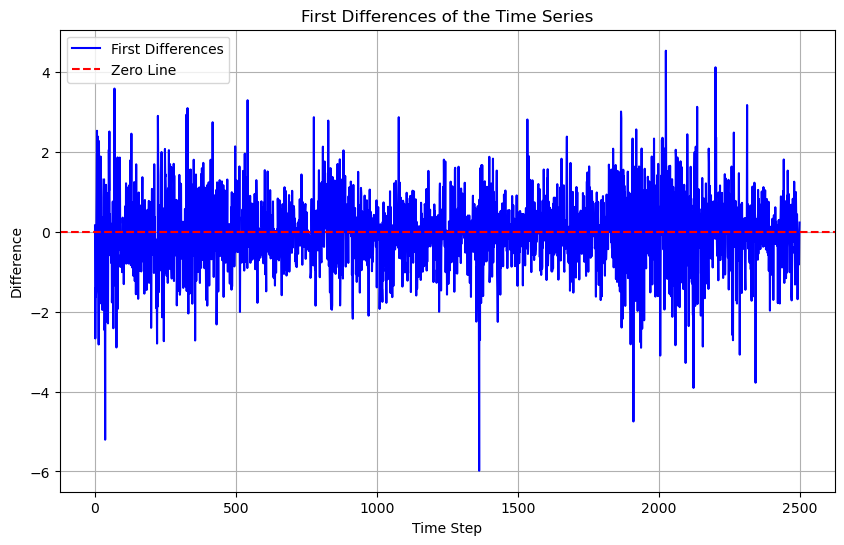

In [61]:
# Compute the first differences
first_diff = np.diff(np.array(new_df['Close']))
first_diff_mean = np.mean(first_diff)
# Plot the first differences
plt.figure(figsize=(10, 6))
plt.plot(first_diff, label='First Differences', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('First Differences of the Time Series')
plt.xlabel('Time Step')
plt.ylabel('Difference')
plt.legend()
plt.grid(True)
plt.show()

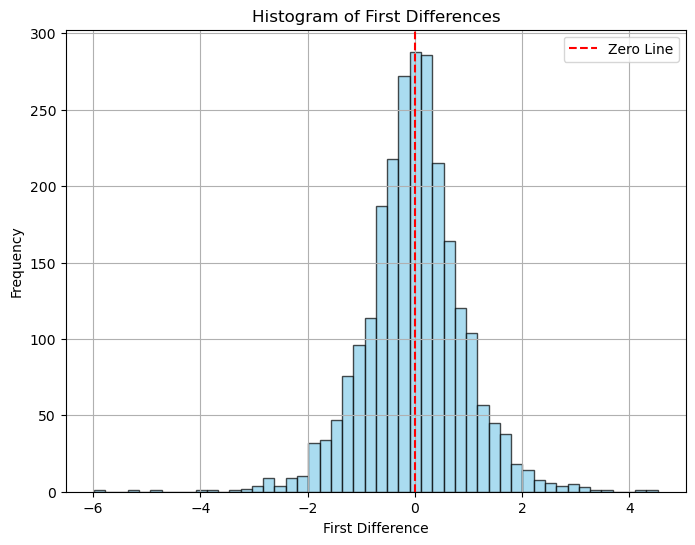

In [62]:
plt.figure(figsize=(8, 6))
plt.hist(first_diff, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.title('Histogram of First Differences')
plt.xlabel('First Difference')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Calculate skewness
skewness_value = skew(first_diff)
print(f"Skewness: {skewness_value}")

# Perform skewness test
statistic, p_value = skewtest(first_diff)
print(f"Skewness Test Statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret result
if p_value < 0.05:
    print("The time series is not symmetric (reject H0).")
else:
    print("The time series is symmetric (fail to reject H0).")

Skewness: -0.17833998393650777
Skewness Test Statistic: -3.622295532299978
p-value: 0.0002920002470987509
The time series is not symmetric (reject H0).


In [64]:
def analyze_random_walk(series):
    results = {}
    
    # Linear regression for drift detection
    time = np.arange(len(series))
    slope, intercept, r_value, p_value, std_err = linregress(time, series)
    results['linear_trend'] = {'slope': slope, 'p_value': p_value, 'significant': p_value < 0.05}
    
    # Mean of first differences
    first_diff = np.diff(series)
    mean_diff = np.mean(first_diff)
    t_stat, t_p_value = ttest_1samp(first_diff, 0)
    results['mean_first_diff'] = {'mean': mean_diff, 't_stat': t_stat, 'p_value': t_p_value, 'significant': t_p_value < 0.05}
    
    # ADF test
    adf_stat, adf_p_value, _, _, _, _ = adfuller(series, regression='ct')  # Include constant and trend
    results['adf_test'] = {'statistic': adf_stat, 'p_value': adf_p_value, 'significant': adf_p_value < 0.05}
    
    # KPSS test
    kpss_stat, kpss_p_value, _, _ = kpss(series, regression='ct')  # Include constant and trend
    results['kpss_test'] = {'statistic': kpss_stat, 'p_value': kpss_p_value, 'significant': kpss_p_value < 0.05}
    
    # Classification
    if results['linear_trend']['significant'] or results['mean_first_diff']['significant']:
        results['classification'] = 'Random Walk with Drift'
    else:
        results['classification'] = 'Plain Random Walk'
    
    return results

In [65]:
analyze_random_walk(np.array(new_df['Close'][0:2000]))

C:\Users\ZHANG-PC\AppData\Local\Temp\ipykernel_17908\2371383575.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p_value, _, _ = kpss(series, regression='ct')  # Include constant and trend


{'linear_trend': {'slope': -0.02474405332377897,
  'p_value': 0.0,
  'significant': True},
 'mean_first_diff': {'mean': -0.018258142972242958,
  't_stat': -0.9225884681608825,
  'p_value': 0.3563331006568238,
  'significant': False},
 'adf_test': {'statistic': -1.855138286253708,
  'p_value': 0.6775842628358791,
  'significant': False},
 'kpss_test': {'statistic': 0.6364359687843415,
  'p_value': 0.01,
  'significant': True},
 'classification': 'Random Walk with Drift'}

In [66]:
# Assume first_diff is your array of first-order differences
n = len(new_df)
split_size = n // 2
# First half
first_part = first_diff[:split_size]
epsilon_bar_1 = np.abs(first_part).mean()

# Second half
second_part = first_diff[split_size:]
epsilon_bar_2 = np.abs(second_part).mean()

# Print results
print("First half mean absolute increment:", epsilon_bar_1)
print("Second half mean absolute increment:", epsilon_bar_2)
# # First half
# first_part = first_diff[:split_size]
# up_vals_1 = first_part[first_part > 0]
# down_vals_1 = first_part[first_part < 0]
# epsilon_bar_up_1 = up_vals_1.mean() if len(up_vals_1) > 0 else np.nan
# epsilon_bar_down_1 = np.abs(down_vals_1.mean()) if len(down_vals_1) > 0 else np.nan

# # Second half
# second_part = first_diff[split_size:]
# up_vals_2 = second_part[second_part > 0]
# down_vals_2 = second_part[second_part < 0]
# epsilon_bar_up_2 = up_vals_2.mean() if len(up_vals_2) > 0 else np.nan
# epsilon_bar_down_2 = np.abs(down_vals_2.mean()) if len(down_vals_2) > 0 else np.nan

# # Print results
# print("First half:")
# print("  epsilon_bar_up:", epsilon_bar_up_1)
# print("  epsilon_bar_down (absolute):", epsilon_bar_down_1)

# print("Second half:")
# print("  epsilon_bar_up:", epsilon_bar_up_2)
# print("  epsilon_bar_down (absolute):", epsilon_bar_down_2)

First half mean absolute increment: 0.659552102661133
Second half mean absolute increment: 0.6905097625463652


In [67]:
# acc_up_list = []
# acc_down_list = []

# for i in range(2):  # Two parts: 0 = first half, 1 = second half
#     part = new_df.iloc[i * split_size : (i + 1) * split_size]
    
#     # True movement and predicted movement
#     y_true = part['Movement_target_T+1']
#     y_pred = part['Movement_exo_T+1']

#     # Masks for up and down
#     up_mask = y_true == 1
#     down_mask = y_true == -1

#     # Accuracy for up
#     acc_up = (y_pred[up_mask] == 1).mean() if up_mask.sum() > 0 else np.nan
#     # Accuracy for down
#     acc_down = (y_pred[down_mask] == -1).mean() if down_mask.sum() > 0 else np.nan

#     acc_up_list.append(acc_up)
#     acc_down_list.append(acc_down)

# # Assign results to readable variable names
# acc_up_part1, acc_up_part2 = acc_up_list
# acc_down_part1, acc_down_part2 = acc_down_list

# # Print results
# print("First half:")
# print("  acc_up:", acc_up_part1)
# print("  acc_down:", acc_down_part1)

# print("Second half:")
# print("  acc_up:", acc_up_part2)
# print("  acc_down:", acc_down_part2)

In [68]:
acc_list = []

for i in range(2):  # Two parts: 0 = first half, 1 = second half
    part = new_df.iloc[i * split_size : (i + 1) * split_size]

    y_true = part['Movement_target_T+1']
    y_pred = part['Movement_exo_T+1']

    acc = (y_pred == y_true).mean() if len(y_true) > 0 else np.nan
    acc_list.append(acc)

# Assign to readable variables
acc_part1, acc_part2 = acc_list

# Print results
print("First half overall accuracy:", acc_part1)
print("Second half overall accuracy:", acc_part2)

First half overall accuracy: 0.5536
Second half overall accuracy: 0.5616


In [69]:
theta = 2*(acc_part1)-1
# theta_up = 2*(acc_up_part1)-1
# theta_down = 2*(acc_down_part1-0.05)-1

## Movement-Prediction-Adjusted Naive Forecast

In [70]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [71]:
# Define features
X = new_df[['Close','Movement_exo_T+1']]  # Features
y = new_df['Close_T+1']  # Target (S&P 500 open at time t+1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle = False)

In [72]:
# y_pred_FMNP = y_pred_FMNP_normalized * (max_close - min_close) + min_close
y_pred_naive = X_test['Close']

In [73]:
movement_pred = X_test['Movement_exo_T+1']
y_pred_adjusted = np.zeros_like(y_pred_naive, dtype=float)
for i in range(len(y_pred_adjusted)):
    if movement_pred.iloc[i] == 1:
        y_pred_adjusted[i] = y_pred_naive.iloc[i] + theta * epsilon_bar_1
    elif movement_pred.iloc[i] == -1:
        y_pred_adjusted[i] = y_pred_naive.iloc[i] - theta * epsilon_bar_1
    else:
        y_pred_adjusted[i] = y_pred_naive.iloc[i]

# Calculate metrics for the adjusted_naive forecast
mse_adjusted = mean_squared_error(y_test, y_pred_adjusted)
rmse_adjusted = np.sqrt(mse_adjusted)
mae_adjusted = mean_absolute_error(y_test, y_pred_adjusted)

# MAPE Calculation
mape_adjusted = np.mean(np.abs((y_test - y_pred_adjusted) / y_test)) * 100

# sMAPE Calculation
smape_adjusted = 100 * np.mean(2 * np.abs(y_test - y_pred_adjusted) / (np.abs(y_test) + np.abs(y_pred_adjusted)))

print(f'Adjusted Naive Results:')
print("Root Mean Squared Error (adjusted Forecast): {:.4f}".format(rmse_adjusted))
print("Mean Absolute Error (adjusted Forecast): {:.4f}".format(mae_adjusted))
print("Mean Absolute Percentage Error (adjusted Forecast): {:.4f}%".format(mape_adjusted))
print("Symmetric Mean Absolute Percentage Error (adjusted Forecast): {:.4f}%".format(smape_adjusted))

Adjusted Naive Results:
Root Mean Squared Error (adjusted Forecast): 0.9343
Mean Absolute Error (adjusted Forecast): 0.6843
Mean Absolute Percentage Error (adjusted Forecast): 2.1291%
Symmetric Mean Absolute Percentage Error (adjusted Forecast): 2.1240%


## Baseline

### Naive

In [74]:
# Calculate metrics for the naive forecast
mse_naive = mean_squared_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(y_test, y_pred_naive)

# MAPE Calculation
mape_naive = np.mean(np.abs((y_test - y_pred_naive) / y_test)) * 100

# sMAPE Calculation
smape_naive = 100 * np.mean(2 * np.abs(y_test - y_pred_naive) / (np.abs(y_test) + np.abs(y_pred_naive)))

# Display the metrics for the naive forecast
print("Root Mean Squared Error (Naive Forecast): {:.4f}".format(rmse_naive))
print("Mean Absolute Error (Naive Forecast): {:.4f}".format(mae_naive))
print("Mean Absolute Percentage Error (Naive Forecast): {:.4f}%".format(mape_naive))
print("Symmetric Mean Absolute Percentage Error (Naive Forecast): {:.4f}%".format(smape_naive))

Root Mean Squared Error (Naive Forecast): 0.9401
Mean Absolute Error (Naive Forecast): 0.6901
Mean Absolute Percentage Error (Naive Forecast): 2.1522%
Symmetric Mean Absolute Percentage Error (Naive Forecast): 2.1465%


### Naive with Drift

In [75]:
n_train = len(y_train)
last_train_value = y_train.iloc[-1]
first_train_value = y_train.iloc[0]
drift = (last_train_value - first_train_value) / (n_train - 1)

y_pred_naive_drift = y_pred_naive + drift
rmse_drift = np.sqrt(mean_squared_error(y_test, y_pred_naive_drift))
mae_drift = mean_absolute_error(y_test, y_pred_naive_drift)
mape_drift = mape(y_test, y_pred_naive_drift)
smape_drift = smape(y_test, y_pred_naive_drift)

print(f'Naive with Drift Results:')
print(f'RMSE:  {rmse_drift:.4f}')
print(f'MAE:   {mae_drift:.4f}')
print(f'MAPE:  {mape_drift:.4f}%')
print(f'SMAPE: {smape_drift:.4f}%')

Naive with Drift Results:
RMSE:  0.9410
MAE:   0.6910
MAPE:  2.1532%
SMAPE: 2.1503%


### IMA(1,1)

In [76]:
# # Fit IMA(1,1) model (ARIMA(0,1,1)) on y_train
# 2. IMA(1,1) model = ARIMA(0,1,1)
# Rolling one-step-ahead forecast for IMA(1,1)
history = list(y_train)
ima_forecast = []

for true_value in y_test:
    # Fit on all available data so far
    model = sm.tsa.ARIMA(endog=history, order=(0, 1, 1))
    model_fit = model.fit()
    # One-step forecast
    yhat = model_fit.forecast(steps=1)[0]
    ima_forecast.append(yhat)
    # Update history with true value
    history.append(true_value)

# 3. Forecast (one-step-ahead, recursively for the whole test set)
y_pred_ima = np.array(ima_forecast)
rmse_ima = np.sqrt(mean_squared_error(y_test, y_pred_ima))
mae_ima = mean_absolute_error(y_test, y_pred_ima)
mape_ima = mape(y_test, y_pred_ima)
smape_ima = smape(y_test, y_pred_ima)

print(f'RMSE:  {rmse_ima:.4f}')
print(f'MAE:   {mae_ima:.4f}')
print(f'MAPE:  {mape_ima:.4f}%')
print(f'SMAPE: {smape_ima:.4f}%')

RMSE:  0.9401
MAE:   0.6907
MAPE:  2.1574%
SMAPE: 2.1521%


### Linear Regression

In [77]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mape(y_test, y_pred_lr)
smape_lr = smape(y_test, y_pred_lr)

print(f'RMSE:  {rmse_lr:.4f}')
print(f'MAE:   {mae_lr:.4f}')
print(f'MAPE:  {mape_lr:.4f}%')
print(f'SMAPE: {smape_lr:.4f}%')

RMSE:  0.9331
MAE:   0.6852
MAPE:  2.1355%
SMAPE: 2.1260%


### Lasso

In [78]:
# Instantiate Lasso regression with a regularization parameter alpha
lasso = Lasso(alpha=1.0)  # alpha can be tuned by cross-validation

# Fit the model
lasso.fit(X_train, y_train)

# Predict on test set
y_pred_lasso = lasso.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mape_lasso = mape(y_test, y_pred_lasso)
smape_lasso = smape(y_test, y_pred_lasso)

print(f'RMSE:  {rmse_lasso:.4f}')
print(f'MAE:   {mae_lasso:.4f}')
print(f'MAPE:  {mape_lasso:.4f}%')
print(f'SMAPE: {smape_lasso:.4f}%')

RMSE:  0.9591
MAE:   0.7126
MAPE:  2.2781%
SMAPE: 2.2494%


### Ridge

In [79]:
# Instantiate Ridge Regression with a chosen regularization parameter (alpha)
ridge = Ridge(alpha=1.0)  # You can tune alpha based on cross-validation

# Fit the Ridge regression model on the training data
ridge.fit(X_train, y_train)

# Predict using the Ridge regression model on the test data
y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mape_ridge = mape(y_test, y_pred_ridge)
smape_ridge = smape(y_test, y_pred_ridge)

print(f'RMSE:  {rmse_ridge:.4f}')
print(f'MAE:   {mae_ridge:.4f}')
print(f'MAPE:  {mape_ridge:.4f}%')
print(f'SMAPE: {smape_ridge:.4f}%')

RMSE:  0.9331
MAE:   0.6852
MAPE:  2.1356%
SMAPE: 2.1260%


### Elastic Net

In [80]:
# Instantiate ElasticNet with parameters alpha and l1_ratio
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5) 
# l1_ratio controls balance between L1 and L2 (0=L2 only, 1=L1 only)

# Fit the model
elastic_net.fit(X_train, y_train)

# Predict on test set
y_pred_enet = elastic_net.predict(X_test)

rmse_enet = np.sqrt(mean_squared_error(y_test, y_pred_enet))
mae_enet = mean_absolute_error(y_test, y_pred_enet)
mape_enet = mape(y_test, y_pred_enet)
smape_enet = smape(y_test, y_pred_enet)

print(f'RMSE:  {rmse_enet:.4f}')
print(f'MAE:   {mae_enet:.4f}')
print(f'MAPE:  {mape_enet:.4f}%')
print(f'SMAPE: {smape_enet:.4f}%')

RMSE:  0.9589
MAE:   0.7124
MAPE:  2.2770%
SMAPE: 2.2484%


In [81]:
print("-" * 40)  # 40-character dash line
# Print results
print("First half overall accuracy:", acc_part1)
print("Second half overall accuracy:", acc_part2)

print("-" * 40)  # 40-character dash line
# Print results
print("First half mean absolute increment:", epsilon_bar_1)
print("Second half mean absolute increment:", epsilon_bar_2)


print("-" * 40)  # 40-character dash line

print(f'Adjusted Naive Results:')
print("Root Mean Squared Error (adjusted Forecast): {:.4f}".format(rmse_adjusted))
print("Mean Absolute Error (adjusted Forecast): {:.4f}".format(mae_adjusted))
print("Mean Absolute Percentage Error (adjusted Forecast): {:.4f}%".format(mape_adjusted))
print("Symmetric Mean Absolute Percentage Error (adjusted Forecast): {:.4f}%".format(smape_adjusted))


print("-" * 40)  # 40-character dash line

print(f'Naive Results:')
print("Root Mean Squared Error (Naive Forecast): {:.4f}".format(rmse_naive))
print("Mean Absolute Error (Naive Forecast): {:.4f}".format(mae_naive))
print("Mean Absolute Percentage Error (Naive Forecast): {:.4f}%".format(mape_naive))
print("Symmetric Mean Absolute Percentage Error (Naive Forecast): {:.4f}%".format(smape_naive))

print("-" * 40)  # 40-character dash line

print(f'Naive with Drift Results:')
print(f'RMSE:  {rmse_drift:.4f}')
print(f'MAE:   {mae_drift:.4f}')
print(f'MAPE:  {mape_drift:.4f}%')
print(f'SMAPE: {smape_drift:.4f}%')

print("-" * 40)  # 40-character dash line

print(f'IMA(1,1) Results:')
print("Root Mean Squared Error (adjusted_Naive Forecast): {:.4f}".format(rmse_ima))
print("Mean Absolute Error (adjusted_1 Forecast): {:.4f}".format(mae_ima))
print("Mean Absolute Percentage Error (adjusted_1 Forecast): {:.4f}%".format(mape_ima))
print("Symmetric Mean Absolute Percentage Error (adjusted_1 Forecast): {:.4f}%".format(smape_ima))


print("-" * 40)  # 40-character dash line

print(f'LR Results:')
print(f'RMSE:  {rmse_lr:.4f}')
print(f'MAE:   {mae_lr:.4f}')
print(f'MAPE:  {mape_lr:.4f}%')
print(f'SMAPE: {smape_lr:.4f}%')



----------------------------------------
First half overall accuracy: 0.5536
Second half overall accuracy: 0.5616
----------------------------------------
First half mean absolute increment: 0.659552102661133
Second half mean absolute increment: 0.6905097625463652
----------------------------------------
Adjusted Naive Results:
Root Mean Squared Error (adjusted Forecast): 0.9343
Mean Absolute Error (adjusted Forecast): 0.6843
Mean Absolute Percentage Error (adjusted Forecast): 2.1291%
Symmetric Mean Absolute Percentage Error (adjusted Forecast): 2.1240%
----------------------------------------
Naive Results:
Root Mean Squared Error (Naive Forecast): 0.9401
Mean Absolute Error (Naive Forecast): 0.6901
Mean Absolute Percentage Error (Naive Forecast): 2.1522%
Symmetric Mean Absolute Percentage Error (Naive Forecast): 2.1465%
----------------------------------------
Naive with Drift Results:
RMSE:  0.9410
MAE:   0.6910
MAPE:  2.1532%
SMAPE: 2.1503%
----------------------------------------


In [ ]:
# Fill in your actual calculated values here:
results = {
    "Stock": ["OIL_"],
    # acc and epsilon
    "acc_1": [acc_part1],
    "acc": [acc_part2],
    "e_1": [epsilon_bar_1],
    "e": [epsilon_bar_2],

    # RMSE
    "rmse_adjusted": [rmse_adjusted],
    "rmse_naive": [rmse_naive],
    "rmse_naive_drift": [rmse_drift],
    "rmse_ima": [rmse_ima],
    "rmse_lr": [rmse_lr],

    # MAE
    "mae_adjusted": [mae_adjusted],
    "mae_naive": [mae_naive],
    "mae_naive_drift": [mae_drift],
        "mae_ima": [mae_ima],
    "mae_lr": [mae_lr],

    # MAPE
    "mape_adjusted": [mape_adjusted],
    "mape_naive": [mape_naive],
    "mape_naive_drift": [mape_drift],
        "mape_ima": [mape_ima],
    "mape_lr": [mape_lr],

    # SMAPE
    "smape_adjusted": [smape_adjusted],
    "smape_naive": [smape_naive],
    "smape_naive_drift": [smape_drift],
        "smape_ima": [smape_ima],
    "smape_lr": [smape_lr],
}

# Convert to DataFrame
df_results = pd.DataFrame(results)
csv_file_path = 'D:\\RESEARCH\\Result\\OIL_Metric.csv'
# Or to CSV
df_results.to_csv(csv_file_path, index=False)

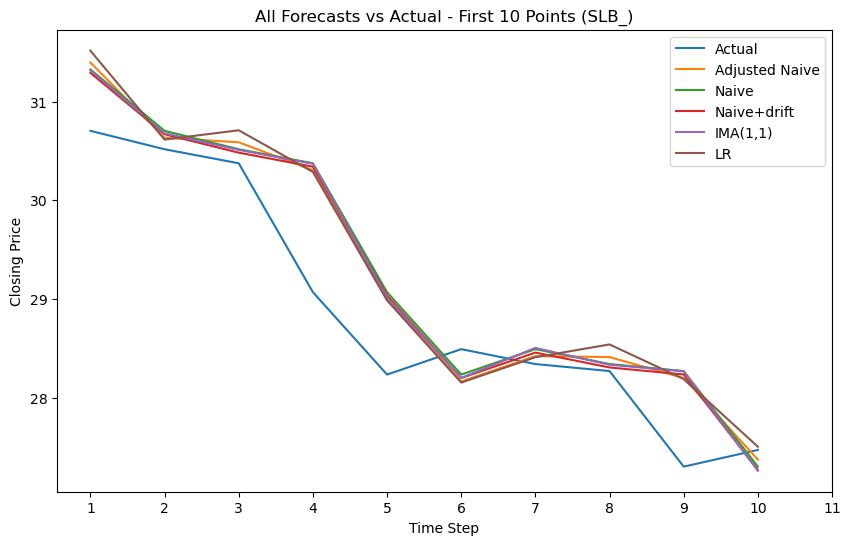

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), y_test[:10], label='Actual')
plt.plot(range(1, 11), y_pred_adjusted[:10], label='Adjusted Naive')
plt.plot(range(1, 11), y_pred_naive[:10], label='Naive')
plt.plot(range(1, 11), y_pred_naive_drift[:10], label='Naive+drift')
plt.plot(range(1, 11), y_pred_ima[:10], label='IMA(1,1)')
plt.plot(range(1, 11), y_pred_lr[:10], label='LR')

plt.title('All Forecasts vs Actual - First 10 Points (OIL_)')
plt.xlabel('Time Step')
# Force the x-axis to use integer values
plt.xticks(range(1, 11 + 1, 1))  # Set ticks to integer range
plt.ylabel('Closing Price')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Fill in your actual prediction arrays here:
results_preds = {
    "Stock": ["OIL_"] * len(y_test),  # Repeat stock name for each row
    "Actual": y_test.values,
    "Adjusted_Naive": y_pred_adjusted,
    "Naive": y_pred_naive,
    "Naive_Drift": y_pred_naive_drift,
    "IMA_1_1": y_pred_ima,
    "LR": y_pred_lr
}

# Convert to DataFrame
df_preds = pd.DataFrame(results_preds)

# Optionally, add index if you want to preserve time information:
# df_preds['Index'] = y_test.index
# df_preds = df_preds.set_index('Index')

# Save to CSV or Excel
csv_file_path = 'D:\\RESEARCH\\Result\\OIL_Preds.csv'
df_preds.to_csv(csv_file_path, index=False)

print(f"Predictions saved to {csv_file_path}")

Predictions saved to D:\RESEARCH\Result\SLB_Preds.csv
